# Regressão Linear

## Objetivos

Os objetivos deste notebook são:

* introduzir os conceitos básicos iniciais de redes neurais através da 
* otimização de um ajuste de pontos por uma reta (linear) utilizando a 
* técnica de cálculo numérico do gradiente descendente. 

É introduzido também:

* o uso de matrizes tanto como 
    * notação matemática como 
    * forma de programação. 

Este notebook contém:
* primeiros programas matriciais de redes neurais, 
* cálculo do gradiente por 3 formas
* laço de otimização pelo gradiente descendente
* plotagem de gráficos.


## Importação dos módulos

O objetivo deste exercício é utilizar apenas as funções do NumPy para o processamento numérico. Iremos precisar entretanto de dois outros pacotes para:

* NumPy: Pacote Numérico do Python - é o que faz o Python ser melhor que o MATLAB
* matplotlib: ferramentas para plotagem de gráficos e imagens
* sklearn: Excelente pacote de "Aprendizagem de Máquina", aqui será usado apenas para carregar o dataset Iris
* pandas: ferramentas de formatação e visualização de dados em forma de tabelas

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

## Problema de Regressão Linear

O problema de ajuste de uma reta a um conjunto de pontos para verificar se existe uma previsão linear é um problema muito antigo, muito estudado e muito presente nos dias de hoje. 

Quando o ajuste é abordado como um problema de **otimização numérica**, ele é a base de boa parte dos **conceitos sobre redes neurais** e iremos explorá-lo aqui como uma forma de introdução às redes neurais. O modelo de regressão linear que iremos utilizar pode
ser visto como uma rede neural de apenas uma camada e função de ativação linear.

## Conjunto de dados: Flores Íris

Iremos utilizar duas propriedades do conjunto de dados das flores Íris [Wikipedia-Iris_flower_data_set](https://en.wikipedia.org/wiki/Iris_flower_data_set):

* o comprimento das sépalas e 
* o comprimento da pétalas. 

A ideia será prever o comprimento da pétala, conhecendo-se o comprimento da sépala. Estaremos usando apenas uma propriedade, ou característica ou *feature* do objeto para que seja fácil visualizar o espaço de busca de parâmetros. 

Vamos utilizar as 50 amostras da variedade versicolor.

![](../figures/iris_petals_sepals.png)

## Dados: leitura e visualização

O carregamento dos dados é feito pelo comando do pacote sklearn: `load_iris`.

In [2]:
iris = load_iris()
print(type(iris))
print('iris.data:',iris.data.shape,iris.data.dtype,iris.data.min(),iris.data.max())
print('iris.target:',iris.target.shape,iris.target.dtype,iris.target.min(),iris.target.max())
#print(iris.DESCR)
print('iris.features_name:',iris.feature_names)
print('iris.target_names:',iris.target_names)

iris_pd = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_pd['target'] = iris.target
iris_pd.head()


<class 'sklearn.datasets.base.Bunch'>
iris.data: (150, 4) float64 0.1 7.9
iris.target: (150,) int64 0 2
iris.features_name: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
iris.target_names: ['setosa' 'versicolor' 'virginica']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


 Iremos utilizar apenas duas informações da variedade versicolor (classe 1): 

* x: comprimento das sépalas,
* y: comprimento das pétalas.

Imprimimos o *shape* dos *arrays* `x` e `y`. O *shape* indica as dimensões do array. Neste caso, observe que possui apenas uma dimensão com 50 elementos cada. 

`x` e `y` são portanto dois arrays unidimensionais com 50 elementos cada, que são o número de amostras da variedade versicolor.

Imprimimos também, a título ilustrativo estes dois vetores:

In [3]:
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x = data[:,0:1]
y = data[:,1:2]

print('x.shape:',x.shape, x.dtype)
print('y.shape:',y.shape, y.dtype)

print('x[:5]:\n', x[:5])
print('y[:5]:\n', y[:5])

x.shape: (50, 1) float64
y.shape: (50, 1) float64
x[:5]:
 [[ 7. ]
 [ 6.4]
 [ 6.9]
 [ 5.5]
 [ 6.5]]
y[:5]:
 [[ 4.7]
 [ 4.5]
 [ 4.9]
 [ 4. ]
 [ 4.6]]


## Visualização dos dados `x` e `y`

A visualização das amostras é feita com o matplotlib, neste caso utilizando o `scatter`:

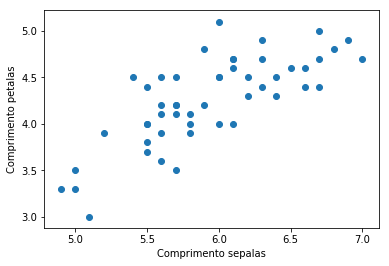

In [4]:
plt.scatter(x, y)
plt.xlabel('Comprimento sepalas')
plt.ylabel('Comprimento petalas')
plt.show()

## Normalização dos dados entre 0 e 1

A equação da normalização dos dados para que o resultado fique entre 0 e 1 é:

$$ y = \frac{x - x_{min}}{x_{max}-x_{min}} $$

Uma forma usual sequencial de fazer esta operação de forma um pouco mais eficiente é:

$$ xx = x - x_{min} \\
   y = \frac{xx}{xx_{max}} $$

Desta forma é usual implementar a normalização através de uma subtração *in place* do mínimo e depois uma divisão também *in place* pelo máximo:

In [5]:
x -= x.min()
x /= x.max()    # normalização
y -= y.min()
y /= y.max()

## Visualização dos dados normalizados


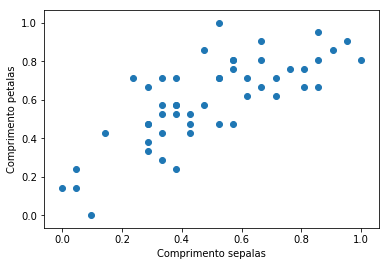

In [6]:
plt.scatter(x, y)
plt.xlabel('Comprimento sepalas')
plt.ylabel('Comprimento petalas')
plt.show()

## Reta de ajuste

A equação da reta no plano necessita de dois parâmetros, aqui denominados $w_0$ (*bias*) e inclinação $w_1$. Veja figura:


<img src="../figures/linhareta.png", width=300pt>

A reta de ajuste será dada por:

$$ \hat{y} = w_0 + w_1 x $$

onde 
* $w_1$ é o coeficiente angular da reta e 
* $w_0$ é a interseção do eixo vertical quando x é igual a zero, também denominado de *bias*.
* $x$ é a variável de entrada (comprimento das sépalas) e 
* $\hat{y}$ é a predição (comprimento estimado das pétalas).

## Representação gráfica da equação linear via neurônio

$ \hat{y} = 1 w_0 + x_0 w_1 $

Temos:
- 1 atributo de entrada: $x_0$
- 2 parâmetros para serem ajustados (treinados) $w_0$ e $w_1$
- 1 classe de saída $\hat{y}$

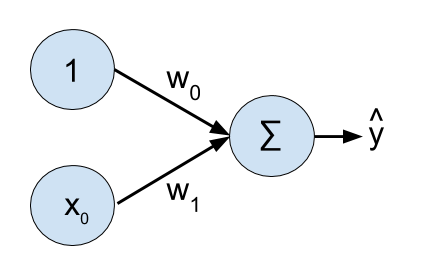

$$ \mathbf{\hat{y}} = \mathbf{x} \mathbf{w}  $$

## Formulação matricial

As redes neurais em geral, são formadas por muitas entradas, várias saídas e vários parâmetros. A melhor forma de se
representar matematicamente as redes neurais são através de matrizes. Apesar desse problema ter apenas uma entrada,
uma saída e dois parâmetros de ajustes, iremos representar na forma matricial, para que a formulação possa ser generalizada para
várias entradas e várias saídas (e várias camadas).

Em notação matricial, iremos usar a convenção de representar vetores em negritos e letras minúsculas,
enquanto que matrizes iremos representar por letras maiúsculas em negrito.

Existem dois casos de formulação matricial: 

1. para representar os neurônios na rede neural;
2. utilizado no processamento de várias amostras simultaneamente. 

Segue a descrição para cada um dos casos:

### Formulação matricial do neurônio

* $\mathbf{x} = \begin{bmatrix}1 & x_0\end{bmatrix}$ é vetor linha de uma amostra (com *bias*),
* $\mathbf{w} = \begin{bmatrix} w_0 \\ w_1 \end{bmatrix} $ é vetor de parâmetros.

$$ \hat{y} = 1 w_0 + x_0 w_1 $$

$$ [\hat{y}] = [1 \ x_0] \begin{bmatrix} w_0 \\ w_1 \end{bmatrix} $$

$$ \mathbf{\hat{y}} = \mathbf{x} \mathbf{w} $$

### Formulação matricial para implementação processando $M$ amostras simultaneamente

Quando temos $M$ amostras, a forma padronizada de organizar os dados de entrada é transpor as informações de cada amostra colocando-a em cada linha da
matriz $\mathbf{X}$:

$$ \mathbf{X} = \begin{bmatrix}
1 & x_0 \\ 
1 & x_1\\
\vdots & \vdots \\ 
1 & x_{M-1}
\end{bmatrix} $$

Desta forma, pode-se calcular o $\hat{y}$ de todas as amostras por:

$$ \begin{matrix} 
\begin{bmatrix}
\hat{y}_0\\ 
\hat{y}_1\\
\\
\hat{y}_{M-1} 
\end{bmatrix} &=& \begin{bmatrix}
1 & x_0 \\ 
1 & x_1\\
\\ 
1 & x_{M-1} \\ 
\end{bmatrix}
&
\begin{bmatrix}
w_0\\ 
w_1
\end{bmatrix} \\
(M,1) & & (M,2) & (2,1) \\
\end{matrix} $$

Na forma matricial:

$$ \mathbf{\hat{y}} = \mathbf{X} \mathbf{w} $$

### Multiplicação Matricial no NumPy

A multiplicação entre matrizes e entre matriz e vetor é implementada em 
Python/Numpy usando o operador `dot`. 
Temos duas notações principais:  
* `X.dot(w)` ou 
* `np.dot(X,w)`. 

As matrizes são caracterizadas pelas suas dimensões que no NumPy são denominados
* `shape` que para matrizes é organizado em 
* `(linhas, colunas)`. 

Na multiplicação $\mathbf{X} \mathbf{w}$, 
* `X.shape=(M,2)` e 
* `w.shape=(2,1)`, cujo resultado da multiplicação será 
* `(M,2)(2,1)->(M,1)` que é o shape do vetor columa $\mathbf{\hat{y}}$.

**Dica:** Operações matriciais tornam o código conciso, escalável e simples, porém, é comum aparecer erros nestas operações e uma das melhores formas de se depurar um programa matricial é verificando
as dimensões (*shape*) das matrizes e vetores em uso.

## Programação Matricial

Como iremos trabalhar com várias amostras, vários parâmetros, várias características e várias classes, é mais eficiente trabalhar com vetores, matrizes e *arrays* por ser uma forma muito mais eficiente de se programar e de se processar. 

Talvez essa seja uma das **principais dificuldades** de programadores de linguagens "estilo C" onde é usual o uso de laços explícitos nos cálculos. 

Neste curso iremos usar o NumPy que é o pacote de *arrays* numéricos que permitem programação matricial de forma muito eficiente.

## Formulação do problema do ajuste da reta como um problema de minimização

Dado um conjunto de $m$ pontos **rotulados** $(x_i,y_i)$ (conjunto de treinamento), 
queremos encontrar uma equação linear de predição do valor de $y$ dado um $x$ desconhecido. 
A equação da predição $\hat{y}$, na forma:

* $ \hat{y} = w_0 + w_1\ x $ 

deve ter seus parâmetros $w_0$ e $w_1$ escolhidos de modo que a soma do erro 
quadrático

* $ \sum (\hat{y_i} - y_i)^2 $ entre as estimativas e o valor das amostras $i$ seja mínimo. 

### Função Custo ou de Perda

A função de custo depende do conjunto de treinamento ($y_i$) e dos valores de predição ($\hat{y_i}$):

$$ J(\hat{y_i},y_i) = \sum_{i=0}^{M-1} (\hat{y_i} - y_i)^2 $$ .

Trocando $\hat{y_i}$ pelo valor da predição, a função de custo depende das amostras de treinamento $x_i, y_i$ e 
do parâmetro de predição $w_i$:

$$ J(x_i,y_i,w_i) = \sum_{i=0}^{M-1} ((w_0 + w_1\ x_i) - y_i)^2 $$ 

Buscamos encontrar os valores de $w_i$ para que $J(x_i,y_i,w_i)$ seja mínimo no conjunto de treinamento ($x_i, y_i$).

Em notação matricial, o cálculo do custo para $M$ amostras fica:

$$ J(\mathbf{w}) = \left \Vert \hat{\mathbf{y}} - \mathbf{y} \right \|^2 = \left \Vert \mathbf{X} \mathbf{w} - \mathbf{y} \right \|^2$$

onde $\left \Vert \textbf{e} \right \|^2$ é a norma do vetor $\textbf{e}$ ao quadrado, dado por:
$\left \Vert \textbf{e} \right \|^2 = \sum_{i}{\textbf{e}_i}^2$

A seguir é mostrado uma implementação matricial desta função:


### compute_cost - formulação matricial

Caso de apenas um $w = \begin{bmatrix} w_0 \\ w_1\end{bmatrix}$ com shape(2,1):

$$ \begin{matrix}
e &=& \begin{bmatrix}
1 & x_0 \\ 
1 & x_1 \\
1 & x_2 \\
\vdots & \vdots \\
1 & x_{M-1}
\end{bmatrix} &
\begin{bmatrix}
w_0\\ 
w_1
\end{bmatrix} &-& \begin{bmatrix}
y_0\\ 
y_1\\ 
\vdots\\ 
y_{M-1}\\ 
\end{bmatrix} &=& \begin{bmatrix}
e_0\\ 
e_1\\ 
\vdots\\ 
e_{M-1}\\ 
\end{bmatrix}\\
& & (M,2) & (2,1) & & (M,1) & & (M,1)
 \end{matrix} $$ 

$$ J = \sum_{i=0}^{M-1} e_i^2 $$

## Minimização via Gradiente Descendente

O problema então se resume em encontrar os coeficientes de $\mathbf{w}$ que minimizem $J(\mathbf{w})$ no conjunto de dados rotulados `(X,y)`. Existem várias formas de se realizar esta otimização. Para fazer uma analogia com as redes neurais, a otimização será obtida por método de cálculo numérico
conhecido como "gradiente descendente". Como o gradiente de uma função aponta sempre para os valores mais altos da função, o método do gradiente descendente consiste em atualizar o valor de $\mathbf{w}$ subtraindo-o proporcionalmente do gradiente, isto é, indo na direção contrária do gradiente na expectativa de que iremos encontrar valores menores.

## Determinação do Gradiente da Função de Custo

O gradiente da função Custo ($\mathbf{\nabla{J_w}}$) para este caso onde 
$\mathbf{w}=\begin{bmatrix}w_0 \\ w_1\end{bmatrix}$ é um vetor de derivadas partiais:

$$ \mathbf{\nabla{J_w}} = \begin{bmatrix} \frac{\partial J}{\partial w_0} \\ \frac{\partial J}{\partial w_1}\end{bmatrix} $$

### Gradiente para uma amostra

Vamos inicialmente calcular o gradiente para uma única amostra e depois iremos generalizar para $M$ amostras. O custo para uma amostra é dado por:

$$ J = (\hat{y} - y)^2 = (\begin{bmatrix} x_0 & x_1 \end{bmatrix}\begin{bmatrix} w_0 \\ w_1 \end{bmatrix}  - y)^2
     = (\mathbf{xw} - y)^2$$
     
$$ J = (w_0 x_0 + w_1 x_1 - y)^2 $$

$$ \frac{\partial J}{\partial w_0} = 2 x_0 (w_0 x_0 + w_1 x_1 - y) = 2 x_0 (\mathbf{xw} - y)$$
$$ \frac{\partial J}{\partial w_1} = 2 x_1 (w_0 x_0 + w_1 x_1 - y) = 2 x_1 (\mathbf{xw} - y)$$

$$\begin{bmatrix} \frac{\partial J}{\partial w_0} \\ \frac{\partial J}{\partial w_1}\end{bmatrix} =
\begin{bmatrix} 2 x_0 (\mathbf{xw} - y) & 2 x_1 (\mathbf{xw} - y)\end{bmatrix} = 2(\mathbf{xw} - y)\mathbf{x}^T
$$
Assim, o gradiente para uma amostra é dado por:
$$ \mathbf{\nabla{J_w}} = 2(\mathbf{xw} - y)\mathbf{x}^T $$

### Gradiente para $M$ amostras, formulação matricial

Vimos anteriormente que quando processamos com várias amostras simultaneamente, utilizamos a matrix $\mathbf{X}$
onde cada linha se refere a uma amostra: ($\mathbf{x}$):

$$ \mathbf{X} = \begin{bmatrix}
\longleftarrow & (\mathbf{x}^{(0)})^T & \longrightarrow \\ 
\longleftarrow & (\mathbf{x}^{(1)})^T & \longrightarrow \\ 
  & \vdots  & \\ 
\longleftarrow & (\mathbf{x}^{(M-1)})^T & \longrightarrow 
\end{bmatrix} = \begin{bmatrix}
x_{0,0} & x_{0,1} \\
x_{1,0} & x_{1,1} \\
\vdots  & \vdots  \\ 
x_{M,0} & x_{M,1} \\
\end{bmatrix} $$

Assim:

$$  (\mathbf{\nabla{J_w}}) = 2 \mathbf{X}^T(\mathbf{Xw} - \mathbf{y}) $$.

### Gradiente descendente

Na equação da atualização do $\mathbf{w}$ a seguir, o fator $\eta$ é denominado *learning rate*. Ele é um parâmetro de ajuste fundamental para o sucesso da otimização: 

$$ \mathbf{w} = \mathbf{w} − \eta (\mathbf{\nabla J_w}) $$

Desta forma então, calculando-se o gradiente de $J(\mathbf{w})$ e substituindo na equação acima temos:

$$ \mathbf{w} = \mathbf{w} − \eta 2 (\mathbf{X}^T(\mathbf{X}\mathbf{w}−\mathbf{y})) $$

Esta equação é implementada dentro da função `gradient_descent`.

Observe que cada atualização dos pesos, o cálculo do gradiente leva em conta todas as amostras
de dados que estão representados na matriz $\mathbf{X}$ que possui $M$ linhas (amostras).

## Laço de minimização via gradiente descendente

O código da próxima célula é a parte principal deste notebook. É aqui que a minimização é feita. É aqui que dizemos que estamos fazendo o *fit*, ou o treinamento do sistema para encontrar o parâmetro $\mathbf{W}$ que minimiza a função de perda $J$. Acompanhamos a convergência da minimização pelo valor da perda a cada iteração, plotando o vetor `J_history`.


O esquema da otimização é representado pelo diagrama a seguir:

<img src="../figures/RegressaoLinear_Otimizacao.png",width = 600pt>

e é implementado pela próxima célula de código:

### Laço de minimização via gradiente descendente - Código

Para fins ilustrativos, iremos calcular o gradiente por 3 métodos:
1. Derivadas parciais, forma analítica
2. Diferenças finitas
3. Back propagation

In [7]:
# Parâmetros do gradiente descendente: número de iterações e taxa de aprendizagem
n_epochs = 10
lr = 0.001

n_samples = y.shape[0]

#Montagem da matriz X agora com os elementos 1 na primeira coluna
X_bias = np.hstack([np.ones(shape=(n_samples,1)), x])
W = np.zeros(shape=(2,1))

loss_history = []
# Laço de otimização do gradiente descendente
for i in range(n_epochs):
    y_pred = X_bias.dot(W)  # Forward - predição

    loss = np.square(y_pred - y).sum() # Loss: Soma dos erros quadráticos
    loss_history.append(loss)
    print(i,loss)
    
    # cálculo do gradiente pelas derivadas parciais
    W_grad = (2.0) * (X_bias.T).dot(X_bias.dot(W) - y)
    
    # cálculo do gradiente pelas diferenças finitas
    eps = 1e-5
    W_grad_df = np.zeros((2,1))
    for j in range(W_grad_df.shape[0]):
        We = np.zeros_like(W_grad_df)
        We[j,0] += eps
        loss_1 = np.square(X_bias.dot(W+We) - y).sum()
        loss_2 = np.square(X_bias.dot(W-We) - y).sum()
        W_grad_df[j,0] = (loss_1 - loss_2)/(2*eps)
        
    # Cálculo do gradiente pelo back propagation
    grad_y_pred = 2.0 * (y_pred - y)
    grad_W_bp = X_bias.T.dot(grad_y_pred)

    print('W_grad:\n',W_grad)
    print('W_grad_df:\n',W_grad_df)
    print('grad_W_bp:\n',grad_W_bp)
    
    # gradiente descendente
    W = W - lr * W_grad
    
print('W final:',W)

0 20.4535147392
W_grad:
 [[-60.        ]
 [-33.66439909]]
W_grad_df:
 [[-60.        ]
 [-33.66439909]]
grad_W_bp:
 [[-60.        ]
 [-33.66439909]]
1 16.0170154506
W_grad:
 [[-52.33922298]
 [-29.68576476]]
W_grad_df:
 [[-52.33922298]
 [-29.68576476]]
grad_W_bp:
 [[-52.33922298]
 [-29.68576476]]
2 12.6233295174
W_grad:
 [[-45.64080295]
 [-26.20544961]]
W_grad_df:
 [[-45.64080295]
 [-26.20544961]]
grad_W_bp:
 [[-45.64080295]
 [-26.20544961]]
3 10.0270693526
W_grad:
 [[-39.78392048]
 [-23.16089898]]
W_grad_df:
 [[-39.78392048]
 [-23.16089898]]
grad_W_bp:
 [[-39.78392048]
 [-23.16089898]]
4 8.04059282237
W_grad:
 [[-34.66292408]
 [-20.49741143]]
W_grad_df:
 [[-34.66292408]
 [-20.49741143]]
grad_W_bp:
 [[-34.66292408]
 [-20.49741143]]
5 6.52041436312
W_grad:
 [[-30.18542604]
 [-18.16715285]]
W_grad_df:
 [[-30.18542604]
 [-18.16715285]]
grad_W_bp:
 [[-30.18542604]
 [-18.16715285]]
6 5.35681388674
W_grad:
 [[-26.27063723]
 [-16.12829431]]
W_grad_df:
 [[-26.27063723]
 [-16.12829431]]
grad_W_bp

### Plot da curva de minimização de J com o número de iterações

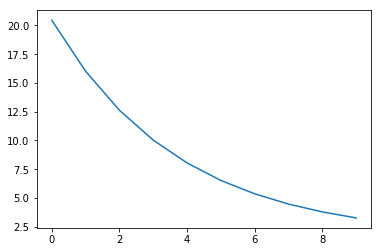

In [8]:
plt.plot(loss_history) # mostrando log para amplificar valores baixos
plt.show()

## Comparando com a solução analítica

A solução analítica deste problema é dada por:

$$  \mathbf{w} =(\mathbf{X}^T \mathbf{X})^{−1}\mathbf{X}^T \mathbf{y} $$

In [9]:
w_opt = (np.linalg.inv((X_bias.T).dot(X_bias)).dot(X_bias.T)).dot(y)
print(w_opt)

[[ 0.26134159]
 [ 0.68646976]]


## Plotagem da reta de predição (solução analítica e solução via gradiente descendente)

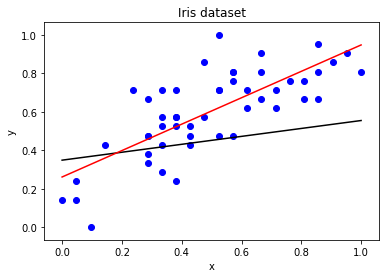

In [10]:
plt.scatter(x, y, marker='o', c='b')
plt.title('Iris dataset')
plt.xlabel('x')
plt.ylabel('y')

# Plotagem da reta utilizando os parâmetros ótimos encontrados no gradiente descendente

X_all = np.linspace(x.min(),x.max(),100).reshape(100,1)
X_all_bias = np.hstack([np.ones((100,1)),X_all])
result = X_all_bias.dot(W)  # Predição via minimização gradiente descendente
plt.plot(X_all, result, c='k')
result_opt = X_all_bias.dot(w_opt)  # Predição do valor analítico
plt.plot(X_all, result_opt,c='r')
plt.show()

## Conclusões desse experimento

Quais são as principais conclusões que podemos tirar deste experimento?

